In [388]:
import pandas as pd
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tensorflow import keras
from tensorflow.keras import layers

plt.rc("figure", figsize=(16,8))
plt.rc("font", size=13)

print("pandas version: " + pd.__version__)
print("numpy version: " + np.__version__)
print("tensorflow version: " + tf.__version__)

pandas version: 1.2.4
numpy version: 1.18.5
tensorflow version: 2.3.1


LSTM: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

In [370]:
combined_df = pd.read_csv("../data/clean/station_trips_weather.csv", parse_dates=["datetime"])
combined_df.set_index("datetime", inplace=True)
combined_df["station_name"] = combined_df["station_name"].astype("category")

In [371]:
combined_df.head(3)

,station_name,check_ins,check_outs,diff,precip_intensity,precip_probability,precip_type,temperature,humidity,wind_speed,wind_bearing,uv_index,visibility
datetime,,,,,,,,,,,,,
2014-01-01,Allende-Platz/Grindelhof,0,5,-5,0.0,0.0,none,1.93,0.81,3.91,161.0,0.0,9.988
2014-01-01,Alsenstraße/Düppelstraße,3,0,3,0.0,0.0,none,1.93,0.81,3.91,161.0,0.0,9.988
2014-01-01,Alsterdorf Markt/Evangelische Stiftung,0,0,0,0.0,0.0,none,1.93,0.81,3.91,161.0,0.0,9.988


In [488]:
combined_df.tail(3)

,station_name,check_ins,check_outs,diff,precip_intensity,precip_probability,precip_type,temperature,humidity,wind_speed,wind_bearing,uv_index,visibility
datetime,,,,,,,,,,,,,
2017-05-15 11:00:00,Winterhuder Weg/ Zimmerstraße,2,4,-2,0.0,0.0,none,14.02,0.71,3.49,276.0,4.0,10.003
2017-05-15 11:00:00,Zentralbibliothek / Münzstraße,0,2,-2,0.0,0.0,none,14.02,0.71,3.49,276.0,4.0,10.003
2017-05-15 11:00:00,Überseering/Mexikoring,1,1,0,0.0,0.0,none,14.02,0.71,3.49,276.0,4.0,10.003


In [505]:
SAMPLE_START_DATE = "2014-05-01"
SAMPLE_END_DATE = "2015-05-01 23:59:59"

In [506]:
sample_df = combined_df[
    pd.Timestamp(SAMPLE_START_DATE):pd.Timestamp(SAMPLE_END_DATE)
][["check_ins", "temperature", "humidity", "uv_index", "wind_speed"]].resample("H").mean()

sample_df.head(3)

,check_ins,temperature,humidity,uv_index,wind_speed
datetime,,,,,
2014-05-01 00:00:00,1.548077,11.98,0.71,0.0,1.80
2014-05-01 01:00:00,1.245192,10.80,0.76,0.0,1.52
2014-05-01 02:00:00,1.139423,9.10,0.85,0.0,2.29


In [507]:
sample_df.interpolate(inplace=True)

In [508]:
sample_df.tail(3)

,check_ins,temperature,humidity,uv_index,wind_speed
datetime,,,,,
2015-05-01 21:00:00,1.264423,9.68,0.62,0.0,2.02
2015-05-01 22:00:00,0.985577,8.67,0.69,0.0,1.89
2015-05-01 23:00:00,0.913462,7.61,0.74,0.0,2.76


In [509]:
# Normalize data

feature_columns = ["temperature", "humidity", "uv_index", "wind_speed"]
label_columns = ["check_ins"]

feature_scaler = StandardScaler()
label_scaler = StandardScaler()

feature_scaler.fit(sample_df[feature_columns])
label_scaler.fit(sample_df[label_columns])

sample_df_scaled = sample_df.reset_index().drop(columns=["datetime"]).copy()

sample_df_scaled["temperature"] = feature_scaler.fit_transform(sample_df["temperature"].values.reshape(-1, 1))
sample_df_scaled["humidity"] = feature_scaler.fit_transform(sample_df["humidity"].values.reshape(-1, 1))
sample_df_scaled["uv_index"] = feature_scaler.fit_transform(sample_df["uv_index"].values.reshape(-1, 1))
sample_df_scaled["wind_speed"] = feature_scaler.fit_transform(sample_df["wind_speed"].values.reshape(-1, 1))

sample_df_scaled["check_ins"] = label_scaler.fit_transform(sample_df["check_ins"].values.reshape(-1, 1))

sample_df_scaled.head(3)

,check_ins,temperature,humidity,uv_index,wind_speed
0,0.470955,0.169196,-0.384482,-0.541699,-0.936378
1,0.148674,0.000622,-0.062654,-0.541699,-1.064196
2,0.036131,-0.242240,0.516635,-0.541699,-0.712698


In [510]:
sequence_length = 24
predict_next = 1

In [511]:
# Split into training, testing and validation data sets
train_data, test_data = train_test_split(
    sample_df_scaled, shuffle=False, train_size=0.8, test_size=0.2
)

In [512]:
def reshape_data(data):
    features = data[feature_columns]
    labels = data[label_columns]
    x = []
    y = []
    for index in range(len(features) - sequence_length):
        feature_sequence = features.iloc[index : (index + sequence_length)].to_numpy()
        label_value = labels.iloc[index + sequence_length]
        x.append(feature_sequence)
        y.append(label_value)
    return np.array(x), np.array(y)

In [513]:
train_x, train_y = reshape_data(train_data)
test_x, test_y = reshape_data(test_data)

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(7003, 24, 4) (7003, 1)
(1733, 24, 4) (1733, 1)


In [518]:
input_shape = (train_x.shape[1], train_x.shape[2])
input_shape

(24, 4)

In [528]:
model = keras.Sequential()
lstm_1 = keras.layers.LSTM(
    units=128,
    activation="relu",
    input_shape=input_shape,
    #return_sequences=True
)
lstm_2 = keras.layers.LSTM(
    units=32,
    activation="relu",
    return_sequences=True
)
dropout = keras.layers.Dropout(0.2)
dense = keras.layers.Dense(1)

model.add(lstm_1)
#model.add(lstm_2)
model.add(dropout)
model.add(dense)

model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_78 (LSTM)               (None, 128)               68096     
_________________________________________________________________
dropout_25 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 129       
Total params: 68,225
Trainable params: 68,225
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
197/197 [==============================] - 3s 16ms/step - loss: 0.5233 - val_loss: 0.2585
Epoch 2/30
197/197 [==============================] - 3s 15ms/step - loss: 0.4499 - val_loss: 0.2239
Epoch 3/30
197/197 [==============================] - 3s 15ms/step - loss: 0.4717 - val_loss: 0.2111
Epoch 4/30
197/197 [==============================] - 3s 15ms/step - loss: 0.4372 - val_loss: 0.2182
Epoch 5/30
197/197 [==============================] - 3s 14ms/step - loss: 0.4109 - val_loss: 0.2218
Epoch 6/30
197/197 [==============================] - 3s 14ms/step - loss: 0.3953 - val_loss: 0.2115
Epoch 7/30
197/197 [==============================] - 3s 15ms/step - loss: 0.3717 - val_loss: 0.2141
Epoch 8/30
197/197 [==============================] - 3s 14ms/step - loss: 0.3623 - val_loss: 0.2142
Epoch 9/30
197/197 [==============================] - 3s 14ms/step - loss: 0.3572 - val_loss: 0.2348
Epoch 10/30
197/197 [==============================] - 3s 14ms/step - loss: 0.3440 - val_lo

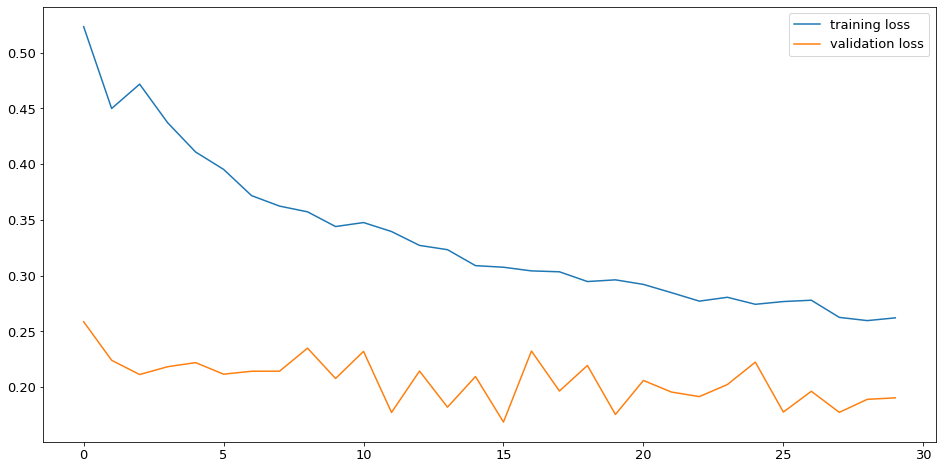

In [529]:
history = model.fit(
    train_x,
    train_y,
    validation_split=0.1,
    epochs=30,
    batch_size=32,
    shuffle=False,
    #verbose=1
)

plt.plot(history.history["loss"], label="training loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.show()

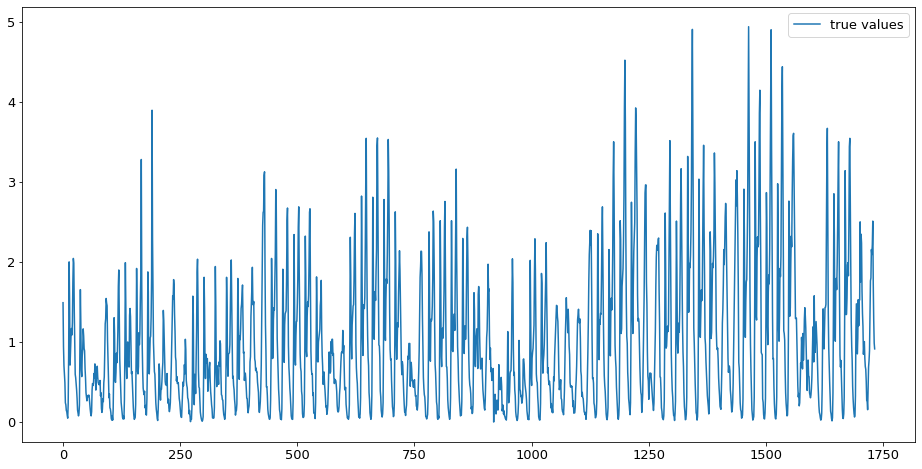

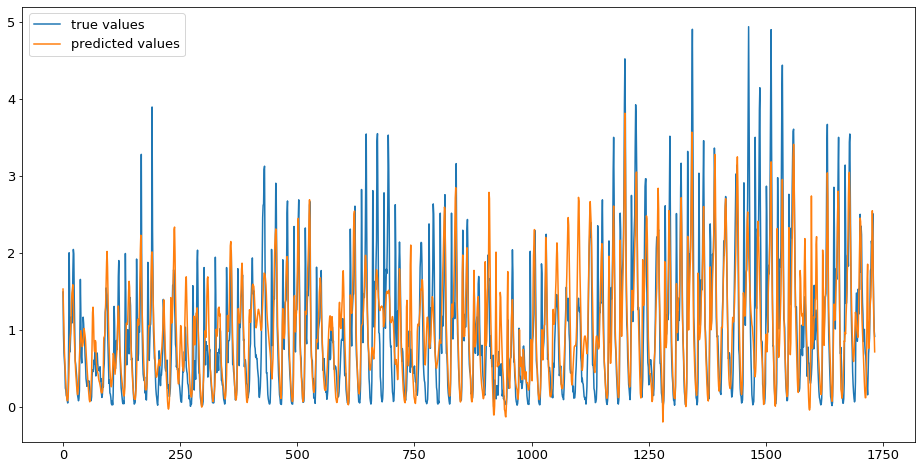

In [530]:
scaled_predictions = model.predict(test_x)

train_y_inv = label_scaler.inverse_transform(train_y)
test_y_inv = label_scaler.inverse_transform(test_y)
predictions = label_scaler.inverse_transform(scaled_predictions)[:,0]

plt.plot(test_y_inv, label="true values")
plt.legend()
plt.show()
plt.plot(test_y_inv, label="true values")
plt.plot(predictions.flatten(), label="predicted values")
plt.legend()
plt.show()